In [1]:
import tensorflow as tf
import PIL
import os
import numpy as np
import cv2
import zipfile
from keras.callbacks import ModelCheckpoint
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential

In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import pathlib

img_height,img_width,batch_size=300,300,32
folder_dir = r"C:\Users\Pranav\Downloads\fa2\fa2\Fabrics_adjusted"
  
train_ds = tf.keras.utils.image_dataset_from_directory(
  folder_dir,
  validation_split=0.2,
  subset="training",
  seed=130,
  image_size=(img_height, img_width),
  batch_size=batch_size)
val_ds = tf.keras.utils.image_dataset_from_directory(
  folder_dir,
  validation_split=0.2,
  subset="validation",
  seed=130,
  image_size=(img_height, img_width), 
  batch_size=batch_size)
class_names=train_ds.class_names

classes={0:"Cotton",1:"Denim",2:"Nylon",3:"Polyester",4:"Silk",5:"Wool"}
class_weights={0:1, 1:4, 2:10, 3:2.5, 4:11, 5:7}

Found 3212 files belonging to 6 classes.
Using 2570 files for training.
Found 3212 files belonging to 6 classes.
Using 642 files for validation.


In [4]:
import matplotlib.pyplot as plt


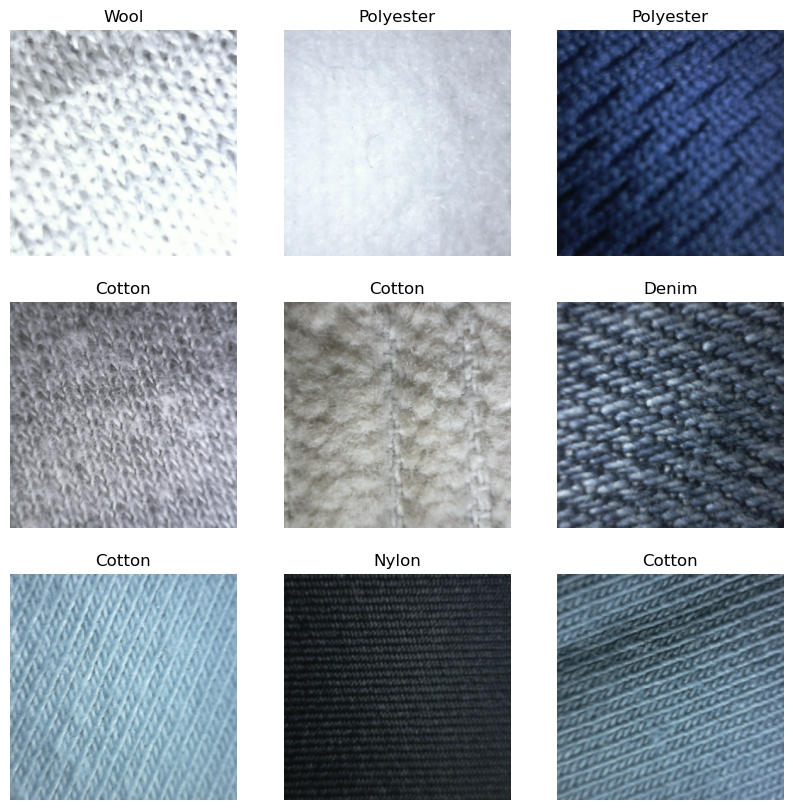

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
def generate_callback(path = "/content/drive/MyDrive/fabric_classification/", filename = "placeholder"):
    checkpoint = ModelCheckpoint(filepath = f'{path}{filename}.h5', monitor='val_accuracy', 
                             verbose=1, save_best_only=True, mode='max')

    return checkpoint

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
da = tf.keras.Sequential(
    [
        tf.keras.layers.RandomRotation(0.5)
    ]
)

In [9]:
num_classes = 6
resnet_model=Sequential()
pretrained_model=tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(img_height,img_width,3),
    pooling='max',
    classes=num_classes
)

for layer in pretrained_model.layers:
    layer.trainable=False

resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(128, activation='relu'))
resnet_model.add(Dropout(0.4))
resnet_model.add(Dense(num_classes, activation='softmax'))

In [10]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 23,850,758
Trainable params: 263,046
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
resnet_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
checkpoint = generate_callback("/content/drive/MyDrive/fabric_classification/", "tomfile")
epochs=15
hist=resnet_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs, callbacks=[checkpoint])

Epoch 1/10


c:\Users\Pranav\anaconda3\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


81/81 [==============================] - ETA: 0s - loss: 2.0391 - accuracy: 0.4712
Epoch 1: val_accuracy improved from -inf to 0.64330, saving model to /content/drive/MyDrive/fabric_classification\tomfile.h5
81/81 [==============================] - 58s 598ms/step - loss: 2.0391 - accuracy: 0.4712 - val_loss: 0.8974 - val_accuracy: 0.6433
Epoch 2/10
81/81 [==============================] - ETA: 0s - loss: 1.0249 - accuracy: 0.5934
Epoch 2: val_accuracy improved from 0.64330 to 0.69470, saving model to /content/drive/MyDrive/fabric_classification\tomfile.h5
81/81 [==============================] - 43s 538ms/step - loss: 1.0249 - accuracy: 0.5934 - val_loss: 0.8283 - val_accuracy: 0.6947
Epoch 3/10
81/81 [==============================] - ETA: 0s - loss: 0.9379 - accuracy: 0.6409
Epoch 3: val_accuracy improved from 0.69470 to 0.74143, saving model to /content/drive/MyDrive/fabric_classification\tomfile.h5
81/81 [==============================] - 43s 538ms/step - loss: 0.9379 - accuracy: 0

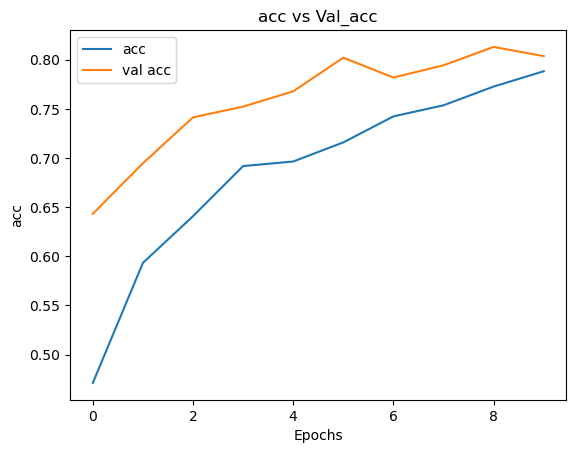

In [12]:
plt.plot(hist.history['accuracy'], label = 'acc')
plt.plot(hist.history['val_accuracy'], label='val acc')
plt.title("acc vs Val_acc")
plt.xlabel("Epochs")
plt.ylabel("acc")
plt.legend()
plt.show()

In [13]:
resnet_model.evaluate(val_ds)

21/21 [==============================] - 9s 427ms/step - loss: 0.4611 - accuracy: 0.8037


[0.4611133337020874, 0.8037382960319519]

In [14]:
prediction=resnet_model.predict(val_ds)
prediction

21/21 [==============================] - 10s 444ms/step


array([[3.0889574e-02, 5.9590171e-08, 3.2643368e-03, 9.6551102e-01,
        4.7903741e-06, 3.3031494e-04],
       [8.6451912e-01, 7.2531309e-04, 8.1540542e-03, 1.1911182e-01,
        4.7846744e-03, 2.7050616e-03],
       [1.2252283e-02, 6.7787900e-05, 1.0238646e-02, 9.7396153e-01,
        7.2214124e-04, 2.7576657e-03],
       ...,
       [1.5891996e-01, 3.7837555e-07, 5.3220559e-03, 8.3426660e-01,
        2.0117148e-04, 1.2898595e-03],
       [1.8787268e-01, 9.3804061e-05, 1.5761236e-02, 7.9022968e-01,
        2.3304296e-03, 3.7121817e-03],
       [7.9099555e-06, 3.3307442e-06, 8.0991529e-05, 8.5728597e-03,
        9.9133497e-01, 1.9737845e-08]], dtype=float32)

In [17]:
converter=tf.lite.TFLiteConverter.from_keras_model(resnet_model)
tflite_model=converter.convert()
open(r"C:\Users\Pranav\Documents\hack\linear.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Pranav\AppData\Local\Temp\tmpi2ls_vcn\assets


INFO:tensorflow:Assets written to: C:\Users\Pranav\AppData\Local\Temp\tmpi2ls_vcn\assets


95019648

In [18]:
pred_val = tf.argmax(prediction, axis=1)
test_val = tf.concat([y for x, y in val_ds], axis=0)

              precision    recall  f1-score   support

           0       0.80      0.82      0.81       165
           1       0.95      0.95      0.95       145
           2       0.89      0.53      0.67        45
           3       0.65      0.87      0.74       159
           4       0.91      0.67      0.78        46
           5       0.96      0.59      0.73        82

    accuracy                           0.80       642
   macro avg       0.86      0.74      0.78       642
weighted avg       0.83      0.80      0.80       642

[[136   3   0  25   0   1]
 [  4 138   0   2   0   1]
 [  2   0  24  19   0   0]
 [ 14   0   3 139   3   0]
 [  3   0   0  12  31   0]
 [ 12   4   0  18   0  48]]
[[136   3   0  25   0   1]
 [  4 138   0   2   0   1]
 [  2   0  24  19   0   0]
 [ 14   0   3 139   3   0]
 [  3   0   0  12  31   0]
 [ 12   4   0  18   0  48]]


C:\Users\Pranav\AppData\Local\Temp\ipykernel_21184\606569438.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + class_names)
C:\Users\Pranav\AppData\Local\Temp\ipykernel_21184\606569438.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + class_names)


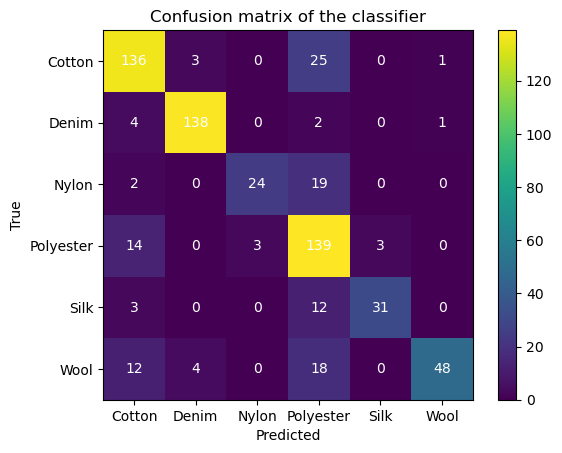

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(test_val, pred_val))
print(confusion_matrix(test_val, pred_val))
cm=confusion_matrix(test_val, pred_val)
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(cm)
plt.title('Confusion matrix of the classifier')
for i in range(6):
    for j in range(6):
        text = ax.text(j, i, cm[i,j],
                       ha="center", va="center", color="w")
fig.colorbar(cax)
ax.set_xticklabels([''] + class_names)
ax.set_yticklabels([''] + class_names)
ax
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

(-0.5, 299.5, 299.5, -0.5)

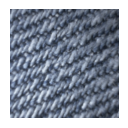

In [21]:
from PIL import Image
from PIL.Image import Resampling
img=Image.open(r"C:\Users\Pranav\Downloads\fa2\fa2\Fabrics_adjusted\Denim\433\im_3.png").resize((300,300))
Image.Resampling.LANCZOS
ax=plt.subplot(3, 3, 3)
plt.imshow(img)
plt.axis("off")

In [22]:
imarr=np.array(img)
imarr.shape

(300, 300, 3)

In [23]:
imarr[np.newaxis, ...].shape

(1, 300, 300, 3)

In [24]:
pred=resnet_model.predict(imarr[np.newaxis, ...])
np.argmax(pred)

1/1 [==============================] - 2s 2s/step


1

In [25]:
pred_label=np.argmax(pred)
class_names[pred_label]

'Denim'